# À propos de ce livret



Recherches liées au développement de cette méthode : 
>San Gultekin, John Paisley (2019). **Online Forecasting Matrix Factorization.**


La méthode implantés provient de ces sources : 
>[**Dépôt 1**](https://github.com/chloemnge/online_learning) *version python*  
>[**Dépôt 2**](https://github.com/xinychen/transdim/blob/master/toy-examples/Prediction-ST-OnlineMF-Gdata.ipynb) *version python*



**Note sur le cachier**

- Vérifier si le fichier peut s'exécuter avec les données manquantes (ou l'endroit où je dois placer les données manquantes...)
- Ajouter de la modularité dans la fonction Online (pour l'instant, elle fonctionne seulement avec l'algorithme FP)
- Pour le format des données : Améliorer le format
- Comprendre ce que le small_dense_mat signifie 

## Préparation préalable à l'utilisation

In [1]:
# Utilités
import os
import time
import numpy as np
import pandas as pd

# Chargement des données
import scipy.io

# Barre de progression
from tqdm.auto import trange
from tqdm import tqdm_notebook, notebook

# Présentation des résultats
import matplotlib.pyplot as plt

In [2]:
os.chdir("C:/Users/amass/OneDrive/02_Education/02_Maitrise/Cours/PROJET_MAITRISE/application")

# Données

## Chargement des données

In [3]:
# Chargement du tenseur de données
tensor = scipy.io.loadmat('data/Guangzhou-data-set/tensor.mat')
tensor = tensor['tensor']

# Chargement de la matrice aléatoire de données
random_matrix = scipy.io.loadmat('data/Guangzhou-data-set/random_matrix.mat')
random_matrix = random_matrix['random_matrix']

# Chargement du tenseur aléatoire de données
random_tensor = scipy.io.loadmat('data/Guangzhou-data-set/random_tensor.mat')
random_tensor = random_tensor['random_tensor']

print("Tensor shape : {:} | Random matrix shape : {:} | Random tensor shape : {:}".format(tensor.shape, 
                                                                                        random_matrix.shape,
                                                                                        random_tensor.shape))

Tensor shape : (214, 61, 144) | Random matrix shape : (214, 61) | Random tensor shape : (214, 61, 144)


## Format des données

In [4]:
petit_donnees = True

# Paramètres du jeu de données tronqué
capteurs = 50
jours = 10
sequences = tensor.shape[2]

matrice = True

if petit_donnees == True:
    tensor = tensor[0:capteurs, 0:jours, 0:sequences]
    
    random_tensor = random_tensor[0:capteurs, 0:jours, 0:sequences]
    

print("The tensors shapes are : {:} | {:}".format(tensor.shape, random_tensor.shape))

if matrice == True:
    dense_mat = tensor.reshape([tensor.shape[0], tensor.shape[1] * tensor.shape[2]])
    
    print("The matrix shape is : {:}".format(dense_mat.shape))

The tensors shapes are : (50, 10, 144) | (50, 10, 144)
The matrix shape is : (50, 1440)


## Scénario de manquants

In [5]:
missing_rate = 0.4

random_missing = True

# Revoir le code pour que les deux choix puissent être respectés sur l'ensemble des matrices/ tenseurs
if random_missing == True:
    print("Random missing (RM) scenario")
    binary_mat = (np.round(random_tensor + 0.5 - missing_rate)
                  .reshape([random_tensor.shape[0], random_tensor.shape[1] * random_tensor.shape[2]]))
    print("\nBinary matrix shape : {:}".format(binary_mat.shape))
else:
    print("Non-random missing (NM) scenario")
    binary_tensor = np.zeros(tensor.shape)
    for i1 in range(tensor.shape[0]):
        for i2 in range(tensor.shape[1]):
            binary_tensor[i1, i2, :] = np.round(random_matrix[i1, i2] + 0.5 - missing_rate)
    binary_mat = binary_tensor.reshape([binary_tensor.shape[0], binary_tensor.shape[1] * binary_tensor.shape[2]])
    print("\nBinary matrix shape : {:}".format(binary_mat.shape))

sparse_mat = np.multiply(dense_mat, binary_mat)

Random missing (RM) scenario

Binary matrix shape : (50, 1440)


# Modèle

## Spécification des modèles

In [6]:
def FP(xt, rho_u, rho_v, Ut_minus, vt_minus, maxiter):
    """
    Fixed Penalty Matrix Factorization (FP)
    
    Paramètres en entré 
        xt : Temps à prédire
        rho_u : bruit sur U / pénalité (?)
        rho_v : bruit sur V
        Ut_minus : U pour le temps d'avant
        vt_minus : V pour le temps d'avant
        maxiter : Nombre d'itérations maximales
        
    Paramètres en sortie 
        Ut : Ut prédit
        vt : Vt prédit
    
    """
    Ut = Ut_minus
    binary_vec = np.zeros(xt.shape)
    pos = np.where(xt > 0)
    binary_vec[pos] = 1
    for i in notebook.tqdm(range(maxiter), desc = "Fixed penality loop", position = 1):
        vt = np.matmul(np.linalg.inv(rho_v * np.eye(vt_minus.shape[0]) +
                                     np.matmul(Ut, Ut.T)),
                       rho_v * vt_minus +
                       np.matmul(Ut, xt))
        Ut = np.matmul(np.linalg.inv(rho_u * np.eye(vt_minus.shape[0]) 
                                     + np.outer(vt, vt)), 
                       rho_u * Ut_minus + np.outer(vt, xt))
    return Ut, vt

In [7]:
def FT(xt, epsilon, rho_v, Ut_minus, vt_minus, maxiter):
    """
    Fixed Tolerance Matrix Factorization (FT)
    
    Paramètres en entré : 
        xt
        epsilon
        rho_v
        Ut_minus
        vt_minus
        maxiter
    Paramètres en sortie : 
        Ut : 
        Vt :
    
    
    """
    Ut = Ut_minus
    for i in range(maxiter):
        vt = np.matmul(np.linalg.inv(rho_v * np.eye(vt_minus.shape[0]) 
                                     + np.matmul(Ut, Ut.T)), 
                       rho_v * vt_minus + np.matmul(Ut, xt))
        c1 = np.linalg.norm(xt - np.matmul(Ut_minus.T, vt)) ** 2
        c2 = np.linalg.norm(vt) ** 2
        lambda_star = np.sqrt(c1)/(c2 * np.sqrt(epsilon)) - 1/c2
        Ut = np.matmul(np.linalg.inv(np.eye(vt_minus.shape[0]) 
                                     + lambda_star * np.outer(vt, vt)), 
                       Ut_minus + lambda_star * np.outer(vt, xt))
        return Ut, vt

In [8]:
def ZT(xt, rho_v, Ut_minus, vt_minus, maxiter):
    """
    Zero Tolerance Matrix Factorization (ZT)
    
    Paramètres en entrée : 
        xt : 
        rho_v : 
        Ut_minus : 
        vt_minus : 
        maxiter : 
    
    Paramètres en sortie : 
        Ut : 
        vt : 
    
    
    
    """
    Ut = Ut_minus
    for i in range(maxiter):
        vt = np.matmul(np.linalg.inv(rho_v * np.eye(vt_minus.shape[0]) 
                                     + np.matmul(Ut, Ut.T)), 
                       rho_v * vt_minus + np.matmul(Ut, xt))
        lambda_vec = (np.matmul(Ut_minus.T, vt) - xt)/(np.linalg.norm(vt) ** 2)
        Ut = Ut_minus - np.outer(vt, lambda_vec)
    return Ut, vt

In [9]:
def OnlineMF(X, pred_time_steps, d, P, r0, rho_u, epsilon, rho_v, maxiter): # Ajouter les paramètres pr les autres modèles
    """Online Forecasting Matrix Factorization.
    
    Paramètres en entrée : 
        X : Matrice à factoriser
        pred_time_steps : temps à prédire (dnas FP U[:It])
        d : rang des matrices
        P : Le nombre de temps dans les données (?)
        r0 : Poids de la matrice (?)
        rho_u : Pénalité sur le Ut (FP)
        epsilon : Taux d'apprentissage (non présent dans l'algorithme ci-dessous !?)
        rho_v : Pénalité sur Vt
        maxiter : Nombre maximal d'itérations
    
    
    Paramètres en sortie : 
        Xt : Matrice factorisée
    
    """
    
    # Initialisation des matrices inférieures
        # Initialisation des paramètres
    binary_mat = np.zeros(X.shape) # Non utilisé 
    pos = np.where(X > 0) # Non utilisé
    binary_mat[pos] = 1 # Non utilisé
    
    np.random.seed(0)
    U0 = np.random.rand(d, X.shape[0])
    np.random.seed(0)
    V0 = np.random.rand(d, X.shape[1])
    np.random.seed(0)
    v0 = np.random.rand(d)
    X_new = X[:, 0 : X.shape[1] - pred_time_steps - 1]
    
    # Initialisation des matrices inférieures
    for i in notebook.tqdm(range(maxiter), desc='Matrix loop'):
        for m in range(X_new.shape[0]):
            U0[:, m] = np.matmul(np.linalg.inv(rho_v * np.eye(d) 
                                               + np.matmul(V0[:, 0 : X_new.shape[1]], 
                                                           V0[:, 0 : X_new.shape[1]].T)), 
                                 np.matmul(V0[:, 0 : X_new.shape[1]], X_new[m, :]))
        for n in range(X_new.shape[1]):
            V0[:, n] = np.matmul(np.linalg.inv(rho_v * np.eye(d) 
                                               + np.matmul(U0, U0.T)), 
                                 np.matmul(U0, X_new[:, n]))
    
    pos1 = np.where(X_new > 0)
    mat0 = np.zeros((P, P))
    vec0 = np.zeros(P)
    
    # Quelle est cette étape?
    for t in notebook.tqdm(range(X_new.shape[1] - P),  desc = "What loop ?"):
        Pt = V0[:, t : t + P]
        mat0 += np.matmul(Pt.T, Pt)
        vec0 += np.matmul(Pt.T, V0[:, t + P])
    
    # Algorithme de mise à jour des paramètres
        # Initialisation pour la mise à jour des paramètres
    theta_vec = np.matmul(np.linalg.inv(mat0 + np.eye(P)), vec0)
    r_l0 = r0 * np.eye(P)
    r_r0 = 0
    Xt = np.zeros((X.shape[0], pred_time_steps))
    Ut = U0
    r_lt_minus = r_l0
    r_rt_minus = r_r0
    
        # Procédures de mise à jour
    for t in notebook.tqdm(range(pred_time_steps), desc = "Pred steps loop"):
        # Étape de prédiction
        Ut_minus = Ut
        Pt = V0[:, X.shape[1] - pred_time_steps + t - 1 - P : X.shape[1] - pred_time_steps + t - 1]
        vt_minus = np.matmul(Pt, theta_vec)
        xt = X[:, X.shape[1] - pred_time_steps + t - 1]
        
        # Mise à jour des paramètres
        Ut, vt = FP(xt, rho_u, rho_v, Ut_minus, vt_minus, maxiter)
        
        
        V0[:, X.shape[1] - pred_time_steps + t - 1] = vt
        r_lt = r_lt_minus + np.matmul(Pt.T, Pt)
        r_rt = r_rt_minus + np.matmul(Pt.T, vt)
        theta_vec = np.matmul(np.linalg.inv(r_lt), r_rt)
        
        r_lt_minus = r_lt
        r_rt_minus = r_rt
        Pt0 = V0[:, X.shape[1] - pred_time_steps + t - P : X.shape[1] - pred_time_steps + t]
        vt = np.matmul(Pt0, theta_vec)
        
        Xt[:, t] = np.matmul(Ut.T, vt)
        
        if (t + 1) % 20 == 0:
            print('Time step: {}'.format(t + 1))
    return Xt

## Entrainement du modèle

In [10]:
# start = time.time()

# Établissement des paramètres pour l'algorithme
pred_time_steps = 720
d = 10
P = 144
r0 = 1
rho_u = 1
epsilon = 0.01
rho_v = 1e-4
maxiter = 200

# Algorithme
Xt = OnlineMF(dense_mat, pred_time_steps, d, P, r0, rho_u, epsilon, rho_v, maxiter)

# Pourquoi ????
small_dense_mat = dense_mat[:, dense_mat.shape[1] - pred_time_steps : dense_mat.shape[1]]
pos = np.where(small_dense_mat > 0)

# Calcul des erreurs
final_mape = np.sum(np.abs(small_dense_mat[pos] - 
                           Xt[pos])/small_dense_mat[pos])/small_dense_mat[pos].shape[0]

final_rmse = np.sqrt(np.sum((small_dense_mat[pos] - 
                             Xt[pos]) ** 2)/small_dense_mat[pos].shape[0])
# end = time.time()


Time step: 20



Time step: 40



Time step: 60



Time step: 80



Time step: 100



Time step: 120



Time step: 140



Time step: 160



Time step: 180



Time step: 200



Time step: 220



Time step: 240



Time step: 260



Time step: 280



Time step: 300



Time step: 320



Time step: 340



Time step: 360



Time step: 380



Time step: 400



Time step: 420



Time step: 440



Time step: 460



Time step: 480



Time step: 500



Time step: 520



Time step: 540



Time step: 560



Time step: 580



Time step: 600



Time step: 620



Time step: 640



Time step: 660



Time step: 680



Time step: 700



Time step: 720



In [11]:
print('Final MAPE: {:.6}'.format(final_mape))
print('Final RMSE: {:.6}'.format(final_rmse))
# print()
# print('Running time: %d seconds'%(end - start))

Final MAPE: 0.0826078
Final RMSE: 3.79483


In [12]:
# Vérification (compréhension des différents paramètres du modèle)
576 + 720 == dense_mat.shape[1] - 144

True

# Présentation des résultats

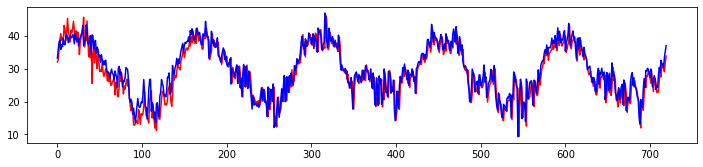

In [13]:
plt.figure(figsize = (12, 2.5))
road = 3
plt.plot(Xt[road, :], 'r', small_dense_mat[road, :], 'b')
plt.show()